In [12]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib import dates as mpl_dates
import seaborn as sns 
import matplotlib.dates as mdates
import datetime
import plotly.express as px
import plotly.graph_objects as go
import os
import arcgis
from arcgis.gis import GIS
from mpl_toolkits.basemap import Basemap, addcyclic
from scipy.ndimage.filters import minimum_filter, maximum_filter
from netCDF4 import Dataset



In [35]:
#Took the CSV and read it in as dataframe
acled_df = pd.read_csv('../data/acled_midterm.csv')
#Converting "event_date" to date type instead of str/object
acled_df['event_date'] = pd.DatetimeIndex(
    acled_df['event_date']
)
acled_df.head(5)

,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,sub_event_type,actor1,...,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3
0,9458560,188,CRI1681,1681,2022-09-01,2022,1,Protests,Peaceful protest,Protesters (Costa Rica),...,San Jose,9.9356,-84.0986,1,Diario Extra; Teletica; La Teja; Amprensa,National,"On 1 September 2022, in San Jose, Hospital, Sa...",0,1663001494,CRI
1,9458592,320,GTM5386,5386,2022-09-01,2022,1,Protests,Peaceful protest,Protesters (Guatemala),...,San Vicente Pacaya,14.4144,-90.6359,2,El Periodico; Prensa Libre (Guatemala),National,"On 1 September 2022, near San Vicente Pacaya, ...",0,1663001494,GTM
2,9458803,484,MEX64680,64680,2022-09-01,2022,2,Violence against civilians,Attack,Unidentified Gang (Mexico),...,Tijuana,32.5325,-117.0190,1,AFN - Tijuana; Riodoce,Subnational-National,"Around 1 September 2022 (as reported), in Tiju...",1,1663001495,MEX
3,9458804,484,MEX64695,64695,2022-09-01,2022,1,Protests,Peaceful protest,Protesters (Mexico),...,Tepeji del Rio de Ocampo,19.9048,-99.3437,2,Diario Via Libre; El Sol de Hidalgo; Milenio,Subnational-National,"On 1 September 2022, in Tepeji del Rio de Ocam...",0,1663001495,MEX
4,9458805,484,MEX64698,64698,2022-09-01,2022,1,Protests,Peaceful protest,Protesters (Mexico),...,Soyaniquilpan de Juarez,20.0149,-99.5302,2,Diario Via Libre; Milenio,National,"On 1 September 2022, between Soyaniquilpan de ...",0,1663001495,MEX


In [36]:
#Objectives with the data
    # Over the past three years has civilian protests increased or decreased per country?
         # Does the quantity of protests correlate with the increase or decrease of social media usage? If so what social media platforms is this country primarily using?
    # Is there a correlation between violence agaianst protestsors and the quantity of protests per country?

acled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803024 entries, 0 to 803023
Data columns (total 31 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   data_id           803024 non-null  int64         
 1   iso               803024 non-null  int64         
 2   event_id_cnty     803024 non-null  object        
 3   event_id_no_cnty  803024 non-null  int64         
 4   event_date        803024 non-null  datetime64[ns]
 5   year              803024 non-null  int64         
 6   time_precision    803024 non-null  int64         
 7   event_type        803024 non-null  object        
 8   sub_event_type    803024 non-null  object        
 9   actor1            803024 non-null  object        
 10  assoc_actor_1     359190 non-null  object        
 11  inter1            803024 non-null  int64         
 12  actor2            334361 non-null  object        
 13  assoc_actor_2     95961 non-null   object        
 14  inte

In [38]:
#Take original "timestamp" column and extract month making a new column in order to map protests by month over a 3 year span
acled_df['month'] = pd.DatetimeIndex(acled_df['event_date']).month_name().str[:3]
acled_df = acled_df.set_index('month')
acled_df.head(5)

,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,sub_event_type,actor1,...,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3
month,,,,,,,,,,,,,,,,,,,,,
Sep,9458560,188,CRI1681,1681,2022-09-01,2022,1,Protests,Peaceful protest,Protesters (Costa Rica),...,San Jose,9.9356,-84.0986,1,Diario Extra; Teletica; La Teja; Amprensa,National,"On 1 September 2022, in San Jose, Hospital, Sa...",0,1663001494,CRI
Sep,9458592,320,GTM5386,5386,2022-09-01,2022,1,Protests,Peaceful protest,Protesters (Guatemala),...,San Vicente Pacaya,14.4144,-90.6359,2,El Periodico; Prensa Libre (Guatemala),National,"On 1 September 2022, near San Vicente Pacaya, ...",0,1663001494,GTM
Sep,9458803,484,MEX64680,64680,2022-09-01,2022,2,Violence against civilians,Attack,Unidentified Gang (Mexico),...,Tijuana,32.5325,-117.0190,1,AFN - Tijuana; Riodoce,Subnational-National,"Around 1 September 2022 (as reported), in Tiju...",1,1663001495,MEX
Sep,9458804,484,MEX64695,64695,2022-09-01,2022,1,Protests,Peaceful protest,Protesters (Mexico),...,Tepeji del Rio de Ocampo,19.9048,-99.3437,2,Diario Via Libre; El Sol de Hidalgo; Milenio,Subnational-National,"On 1 September 2022, in Tepeji del Rio de Ocam...",0,1663001495,MEX
Sep,9458805,484,MEX64698,64698,2022-09-01,2022,1,Protests,Peaceful protest,Protesters (Mexico),...,Soyaniquilpan de Juarez,20.0149,-99.5302,2,Diario Via Libre; Milenio,National,"On 1 September 2022, between Soyaniquilpan de ...",0,1663001495,MEX


In [39]:
#separate protests in the event_type column
acled_event_protests = acled_df.loc[acled_df['event_type'] == 'Protests']
acled_event_protests['data_id'].count()


423413

In [58]:
acled_df_sort_bar = acled_event_protests.value_counts('actor1') 
acled_df_sort_bar

actor1
Protesters (India)                         44573
Protesters (United States)                 43267
Protesters (Pakistan)                      21058
Protesters (Mexico)                        17740
Protesters (France)                        17346
                                           ...  
Protesters (Tonga)                             1
Protesters (Montserrat)                        1
Protesters (Rwanda)                            1
Protesters (Saint Kitts and Nevis)             1
Unidentified Communal Militia (Nigeria)        1
Length: 245, dtype: int64

C:\Users\Morgan\AppData\Local\Temp\ipykernel_42796\3477217649.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(acled_df_sort_bar.index, rotation=90, horizontalalignment = 'right', fontsize = '12')


<function matplotlib.pyplot.show(close=None, block=None)>

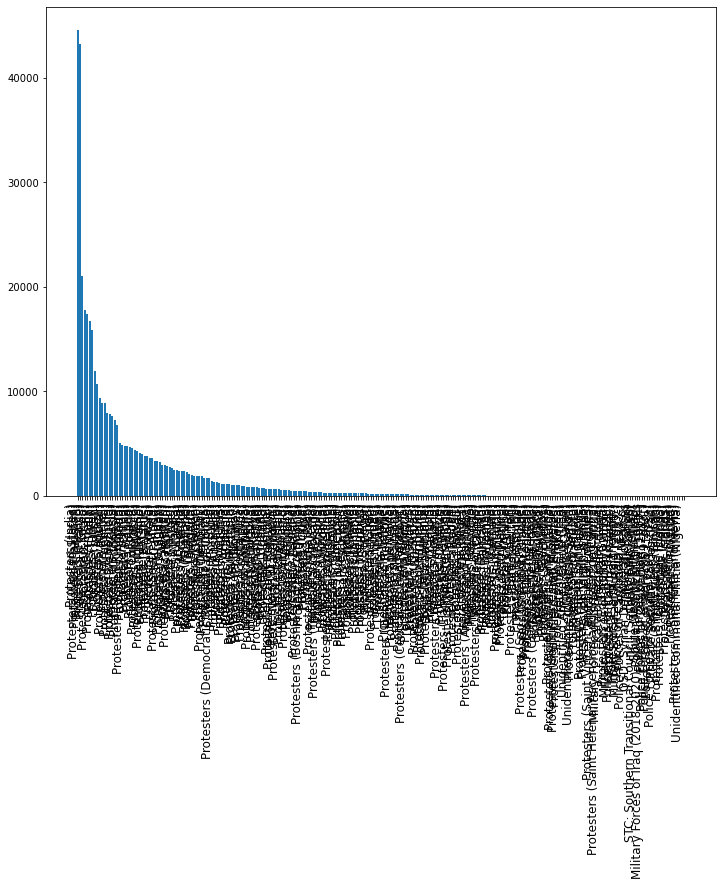

In [60]:
fig, ax = plt.subplots(figsize=(12,9))
ax.bar(acled_df_sort_bar.index, acled_df_sort_bar)
ax.set_xticklabels(acled_df_sort_bar.index, rotation=90, horizontalalignment = 'right', fontsize = '12')
plt.show

In [18]:
#Count of rows for evet type "protests" grouped by year as a test to confirm that filtering the datetime was working as its supposed to.
#acled_df.loc[acled_df['event_type'] == 'Protests'].groupby(by='year').count()
#acled_event_protests[(acled_event_protests['event_date'] > pd.Timestamp('01 September 2020'))].groupby(by='year').count()


In [19]:
# because i dont want to know the world protests summed I am going to identify how many locations exist in the actor1 column

acled_event_protests['actor1'].value_counts()

Protesters (India)                     44573
Protesters (United States)             43267
Protesters (Pakistan)                  21058
Protesters (Mexico)                    17740
Protesters (France)                    17346
                                       ...  
Protesters (Christmas Islands)             1
Protesters (Congo)                         1
Protesters (Montserrat)                    1
Protesters (British Virgin Islands)        1
Police Forces of Iran (1989-)              1
Name: actor1, Length: 245, dtype: int64

In [20]:
# I mapped all the data from above. it ended up being to much data to coherently identify what the data was telling us. So now I will break it down by year and map the data by year.
acled_event_protests_201909_202009 = acled_event_protests[(acled_event_protests['event_date'] > '01 September 2019') & (acled_event_protests['event_date'] <= '31 August 2020')]
acled_event_protests_201909_202009


,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,sub_event_type,actor1,...,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3
month,,,,,,,,,,,,,,,,,,,,,
Jan,7177710,422,LBN5756,5756,2020-08-31,2020,1,Protests,Peaceful protest,Protesters (Lebanon),...,Rabieh,33.9200,35.6024,1,Megaphone News; An-Nahar,New media-National,"On 31 August 2020, protesters gathered outside...",0,1618498748,LBN
Jan,7177802,792,TUR13242,13242,2020-08-31,2020,1,Protests,Peaceful protest,Protesters (Turkey),...,Diyarbakir,37.9136,40.2172,1,Ihlas News Agency; Haberler,National,"On 31 August 2020, families who claim their ch...",0,1618498724,TUR
Jan,7177804,792,TUR13244,13244,2020-08-31,2020,1,Protests,Peaceful protest,Protesters (Turkey),...,Kucukcekmece,40.9960,28.7748,1,Haberler; Ihlas News Agency,National,"On 31 August 2020, a group of wedding venue ow...",0,1599494150,TUR
Jan,7177805,792,TUR13245,13245,2020-08-31,2020,1,Protests,Peaceful protest,Protesters (Turkey),...,Mersin,36.8004,34.6128,1,Mezopotamya Agency; Demokrat Haber,National,"On 31 August 2020, a demonstration was held ou...",0,1618498724,TUR
Jan,7178175,792,TUR13247,13247,2020-08-31,2020,1,Protests,Peaceful protest,Protesters (Turkey),...,Umraniye,41.0164,29.1248,1,Aydinlik,National,"On 31 August 2020, a group of workers dismisse...",0,1599494151,TUR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Jan,9323843,729,SUD13142,13142,2019-09-02,2019,1,Protests,Peaceful protest,Protesters (Sudan),...,Khartoum,15.5725,32.5364,1,Radio Dabanga,National,"On 2 September 2019, journalists and members o...",0,1653503189,SDN
Jan,9333431,792,TUR9149,9149,2019-09-02,2019,1,Protests,Protest with intervention,Protesters (Turkey),...,Ankara,39.9117,32.8403,1,Human Rights Foundation of Turkey,Other,"On 2 September 2019, the former public workers...",0,1653503224,TUR
Jan,9404262,360,IDN1163,1163,2019-09-02,2019,1,Protests,Peaceful protest,Protesters (Indonesia),...,Tasikmalaya,-7.3662,108.2176,1,Tribunnews,National,"On 2 September 2019, a group of students, incl...",0,1657632894,IDN


In [21]:
acled_event_protests_202009_202109 = acled_event_protests[(acled_event_protests['event_date'] > '01 September 2020') & (acled_event_protests['event_date'] <= '31 August 2021')]
acled_event_protests_202009_202109

,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,sub_event_type,actor1,...,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3
month,,,,,,,,,,,,,,,,,,,,,
Jan,8425590,792,TUR17546,17546,2021-08-31,2021,1,Protests,Peaceful protest,Protesters (Turkey),...,Altindag,39.9667,32.9225,1,Anadolu Agency,National,"On 31 August 2021, Hizmet-Is member health wor...",0,1630956703,TUR
Jan,8425595,275,PSE11816,11816,2021-08-31,2021,1,Protests,Peaceful protest,Protesters (Palestine),...,Al Bireh,31.9053,35.2150,1,Arab 48,National,"On 31 August 2021, dozens of Palestinians prot...",0,1630956703,PSE
Jan,8425600,422,LBN12035,12035,2021-08-31,2021,1,Protests,Peaceful protest,Protesters (Lebanon),...,Aaiyat,34.5356,36.1972,2,El Nashra,National,"On 31 August 2021, townspeople stood on the ro...",0,1630956703,LBN
Jan,8425601,422,LBN12033,12033,2021-08-31,2021,1,Protests,Peaceful protest,Protesters (Lebanon),...,Bezbina,34.5153,36.1961,2,El Nashra,National,"On 31 August 2021, protesters stood on the Bay...",0,1630956703,LBN
Jan,8425612,422,LBN12020,12020,2021-08-31,2021,1,Protests,Peaceful protest,Protesters (Lebanon),...,Beirut - Port,33.8982,35.5074,1,El Nashra,National,"On 31 August 2021, truck drivers blocked the e...",0,1630956703,LBN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Jan,9197453,729,SUD14265,14265,2020-09-02,2020,1,Protests,Peaceful protest,Protesters (Sudan),...,Khartoum,15.5725,32.5364,1,Radio Dabanga,National,"On 2 September 2020, demonstrators (including ...",0,1652126674,SDN
Jan,9244444,410,KOR5858,5858,2020-09-02,2020,1,Protests,Peaceful protest,Protesters (South Korea),...,Jinju,35.1803,128.1087,1,Gyeongnam Ilbo; Busan Ilbo,Subnational-National,"On 2 September 2020, members of the South Gyeo...",0,1652826265,KOR
Jan,9404203,360,IDN4627,4627,2020-09-02,2020,1,Protests,Peaceful protest,Protesters (Indonesia),...,Tembagapura,-4.1424,137.0900,1,Suara Papua,National,"On 2 September 2020, a group of mineworkers fr...",0,1657632894,IDN


In [22]:
acled_event_protests_202109_202209 = acled_event_protests[(acled_event_protests['event_date'] > '01 September 2021') & (acled_event_protests['event_date'] <= '31 August 2022')]
acled_event_protests_202109_202209

,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,sub_event_type,actor1,...,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3
month,,,,,,,,,,,,,,,,,,,,,
Jan,9458591,320,GTM5385,5385,2022-08-31,2022,1,Protests,Peaceful protest,Protesters (Guatemala),...,Guatemala City,14.6225,-90.5184,1,El Periodico; Prensa Libre (Guatemala),National,"On 31 August 2022, in Guatemala City, Guatemal...",0,1663001494,GTM
Jan,9458801,484,MEX64668,64668,2022-08-31,2022,1,Protests,Peaceful protest,Protesters (Mexico),...,Culiacan Rosales,24.8088,-107.3940,1,Riodoce; El Sol de Sinaloa,Subnational,"On 31 August 2022, in Culiacan Rosales, Sinalo...",0,1663001495,MEX
Jan,9458802,484,MEX64676,64676,2022-08-31,2022,1,Protests,Peaceful protest,Protesters (Mexico),...,Villa Emiliano Zapata,19.3635,-96.6578,1,La Jornada; Imagen del Golfo,Subnational-National,"On 31 August 2022, in Villa Emiliano Zapata, V...",0,1663001495,MEX
Jan,9458846,630,PRT1298,1298,2022-08-31,2022,1,Protests,Protest with intervention,Protesters (Puerto Rico),...,San Juan,18.4663,-66.1057,1,El Vocero de Puerto Rico; El Nuevo Dia (Puerto...,National,"On 31 August 2022, in San Juan, San Juan, citi...",0,1663001495,PRI
Jan,9459068,484,MEX64679,64679,2022-08-31,2022,1,Protests,Peaceful protest,Protesters (Mexico),...,Xalapa-Enriquez,19.5271,-96.9226,1,Diario Contra Poder en Chiapas,National,"On 31 August 2022, in Xalapa-Enriquez, Veracru...",0,1663001496,MEX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Jan,9208615,124,CAN1074,1074,2021-09-02,2021,1,Protests,Peaceful protest,Protesters (Canada),...,Montreal - Center East,45.5064,-73.5598,1,24 Heures Montreal; Le Journal de Quebec; La P...,Subnational-National,"On 2 September 2021, around 100 people gathere...",0,1652228147,CAN
Jan,9208617,124,CAN1141,1141,2021-09-02,2021,1,Protests,Protest with intervention,Protesters (Canada),...,Vancouver,49.2572,-123.1004,1,Georgia Straight; The Province (Canada); Victo...,Subnational-National,"On 2 September 2021, around 75 people marched ...",0,1652228147,CAN
Jan,9245386,410,KOR18642,18642,2021-09-02,2021,1,Protests,Peaceful protest,Protesters (South Korea),...,Suwon,37.2809,127.0071,1,YNA,National,"On 2 September 2021, about 4 Gyeonggi Provinci...",0,1652826268,KOR


In [23]:
# map dev with ArcGIS... not sure i like it
#map1 = gis.map('USA')
#map1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


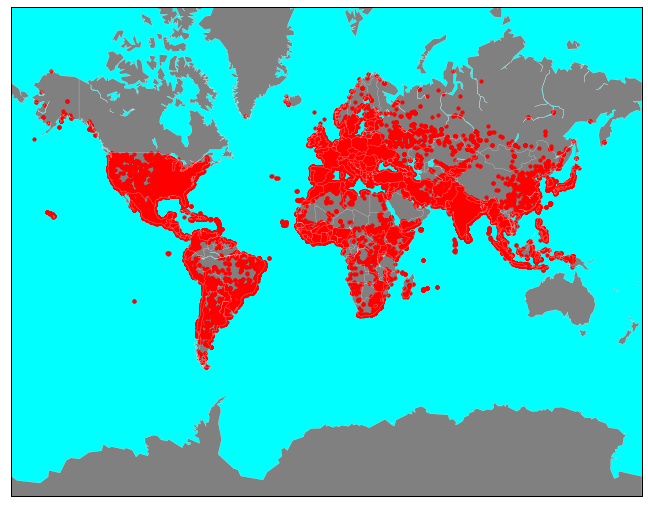

<Figure size 432x288 with 0 Axes>

In [26]:
fig = plt.figure(figsize=(12,9))
lat = acled_event_protests_201909_202009['latitude'].values
lon = acled_event_protests_201909_202009['longitude'].values
protests = acled_event_protests_201909_202009['event_type'].values
#area = acled_event_protests
m = Basemap(projection='merc', \
            llcrnrlat=-80, urcrnrlat=80, \
            llcrnrlon=-180, urcrnrlon=180, \
            lat_ts=20, \
            resolution='c')

m.bluemarble(scale=0.2)
m.drawcoastlines(color='white', linewidth=0.2)
m.drawcountries(color='white', linewidth=0.2)

m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='grey')
lons = range(50)
lats = range(25, 75)
vals = range(50,100)

x, y = m(lon, lat)
plt.scatter(x, y, 10, marker='o', color='Red') 
#plt.scatter(lons, lats, c=vals, cmap='Reds')
#plt.colorbar()
plt.show()
plt.savefig('../images/Protests_2019_2020.png', bbox_inches = 'tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


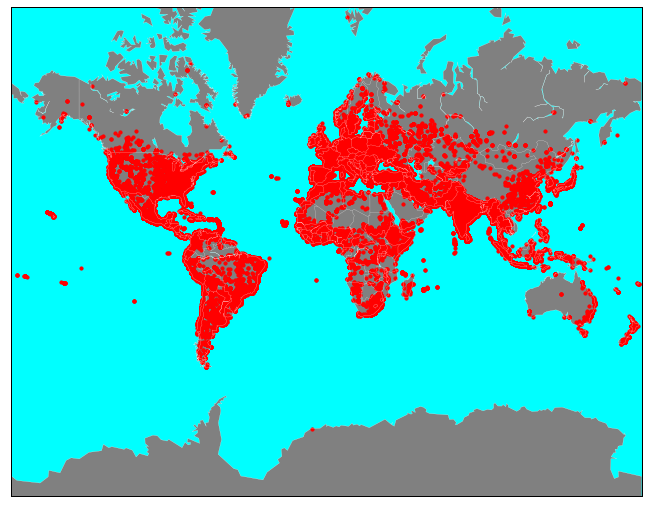

<Figure size 432x288 with 0 Axes>

In [27]:
fig = plt.figure(figsize=(12,9))
lat = acled_event_protests_202009_202109['latitude'].values
lon = acled_event_protests_202009_202109['longitude'].values
protests = acled_event_protests_202009_202109['event_type'].values
#area = acled_event_protests
m = Basemap(projection='merc', \
            llcrnrlat=-80, urcrnrlat=80, \
            llcrnrlon=-180, urcrnrlon=180, \
            lat_ts=20, \
            resolution='c')

m.bluemarble(scale=0.2)
m.drawcoastlines(color='white', linewidth=0.2)
m.drawcountries(color='white', linewidth=0.2)

m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='grey')
lons = range(50)
lats = range(25, 75)
vals = range(50,100)

x, y = m(lon, lat)
plt.scatter(x, y, 10, marker='o', color='Red') 
#plt.scatter(lons, lats, c=vals, cmap='Reds')
#plt.colorbar()
plt.show()
plt.savefig('../images/Protests_2020_2021.png', bbox_inches = 'tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


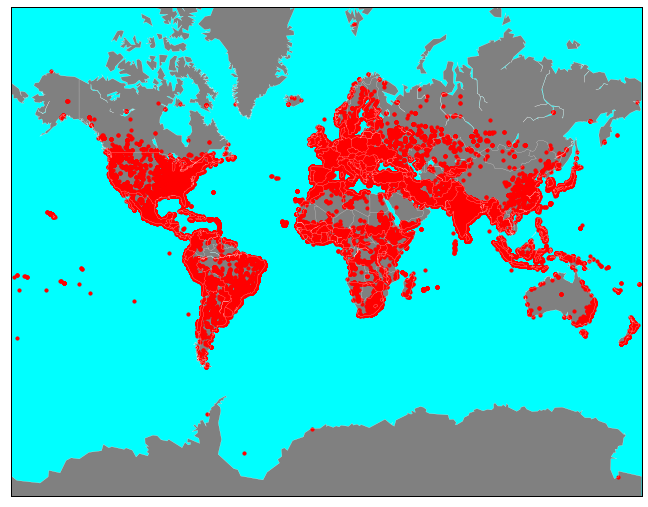

<Figure size 432x288 with 0 Axes>

In [28]:
fig = plt.figure(figsize=(12,9))
lat = acled_event_protests_202109_202209['latitude'].values
lon = acled_event_protests_202109_202209['longitude'].values
protests = acled_event_protests_202109_202209['event_type'].values
#area = acled_event_protests
m = Basemap(projection='merc', \
            llcrnrlat=-80, urcrnrlat=80, \
            llcrnrlon=-180, urcrnrlon=180, \
            lat_ts=20, \
            resolution='c')

m.bluemarble(scale=0.2)
m.drawcoastlines(color='white', linewidth=0.2)
m.drawcountries(color='white', linewidth=0.2)

m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='grey')
lons = range(50)
lats = range(25, 75)
vals = range(50,100)

x, y = m(lon, lat)
plt.scatter(x, y, 10, marker='o', color='Red') 
#plt.scatter(lons, lats, c=vals, cmap='Reds')
#plt.colorbar()
plt.show()
plt.savefig('../images/Protests_2021_2022.png', bbox_inches = 'tight')
